In [1]:
from scipy import stats
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
import tensorflow as tf
import pandas as pd
import sys
import time
from IPython.display import clear_output, Image, display, HTML

/Users/alexanderkornyukhin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def next_batch_no_labels(num, data):
    '''
    Return a total of `num` random samples. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    return np.asarray(data_shuffle)

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

# Training data preperation

## All images (Z machine)

In [34]:
import os
from tqdm import tqdm_notebook
from PIL import Image

directory = './machine_z/'

data_z = np.empty((1024, 1))

for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = Image.open(directory+file).convert("L").resize((32,32))
        img_array = np.asarray(img)
        img_array_reshape = np.reshape(img_array, (1024,1))
        
        data_z = np.append(data_z, img_array_reshape, axis=1)
#         print(file)

data_z = np.delete(data_z, 0, 1)

HBox(children=(IntProgress(value=0, max=33053), HTML(value='')))

In [35]:
df_z = pd.DataFrame(data_z)
store = pd.HDFStore('./machine_data.h5')
store['/machine_z'] = df_z
store.close()

## All images (Y machine)

In [120]:
import os
from tqdm import tqdm_notebook
from PIL import Image

directory = './machine_y/'

data_y = np.empty((1024, 1))

for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = Image.open(directory+file).convert("L").resize((32,32))
        img_array = np.asarray(img)
        img_array_reshape = np.reshape(img_array, (1024,1))
        
        data_y = np.append(data_y, img_array_reshape, axis=1)
#         print(file)

data_y = np.delete(data_y, 0, 1)

HBox(children=(IntProgress(value=0, max=24774), HTML(value='')))

In [121]:
df_y = pd.DataFrame(data_y)
store = pd.HDFStore('./machine_data.h5')
store['/machine_y'] = df_y
store.close()

# Model for 32x32 images (Machine Z)

In [38]:
store = pd.HDFStore('./machine_data.h5')
df_z = store['/machine_z']
store.close()

data_z = df_z.values

In [39]:
data_z.shape

(1024, 33053)

In [40]:
train = data_z[:,:30000]/255.
test = data_z[:,30000:]/255.

In [44]:
SEED = 42
# SEED = 432748

m = train.shape[0] # col
n = train.shape[1] # row
train_T = train.T

# reset the tensor flow graph
reset_graph(seed=SEED)

n_inputs = 1024
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = 128
n_hidden4 = 64
n_hidden5 = 32 # codings
n_hidden6 = n_hidden4
n_hidden7 = n_hidden3
n_hidden8 = n_hidden2
n_hidden9 = n_hidden1

n_outputs = n_inputs

learning_rate = 0.01

# use Gaussian noise 
noise_level = 0.1

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='input') # name referred to when reinstantiating the model
# X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.tanh,name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.tanh, name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.tanh,name="hidden3")    
hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.tanh,name="hidden4")
hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.tanh,name="hidden5")
hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.nn.tanh,name="hidden6")
hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.nn.tanh,name="hidden7")
hidden8 = tf.layers.dense(hidden7, n_hidden8, activation=tf.nn.tanh,name="hidden8")
hidden9 = tf.layers.dense(hidden8, n_hidden9, activation=tf.nn.tanh,name="hidden9")
outputs = tf.layers.dense(hidden9, n_outputs, name="outputs")        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 100
batch_size = 128

loss_history = []

np.random.seed(SEED)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        start = time.clock()
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = next_batch_no_labels(batch_size, train_T)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        loss_history.append(loss_train)
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        print("Time taken: {0} seconds".format((time.clock()-start)))
        print("")
        saver.save(sess, "./logs/machine_z_model.ckpt")

0 Train MSE: 0.011510692
Time taken: 17.599239000000125 seconds

1 Train MSE: 0.013676079
Time taken: 18.09432899999956 seconds

2 Train MSE: 0.015611337
Time taken: 16.84857000000011 seconds

3 Train MSE: 0.01332302
Time taken: 17.535603000000265 seconds

4 Train MSE: 0.0231197
Time taken: 17.62238200000047 seconds

5 Train MSE: 0.016345996
Time taken: 17.55339499999991 seconds

6 Train MSE: 0.010711791
Time taken: 16.87809500000003 seconds

7 Train MSE: 0.009600857
Time taken: 17.1169689999997 seconds

8 Train MSE: 0.012152818
Time taken: 17.461299999999937 seconds

9 Train MSE: 0.017962735
Time taken: 17.01195800000005 seconds

10 Train MSE: 0.013052254
Time taken: 17.59249499999987 seconds

11 Train MSE: 0.021266181
Time taken: 17.737699999999677 seconds

12 Train MSE: 0.015212634
Time taken: 17.210598000000573 seconds

13 Train MSE: 0.014362574
Time taken: 17.746605000000272 seconds

14 Train MSE: 0.027957276
Time taken: 17.279529999999795 seconds

15 Train MSE: 0.03296549
Time ta

Text(0,0.5,'MSE')

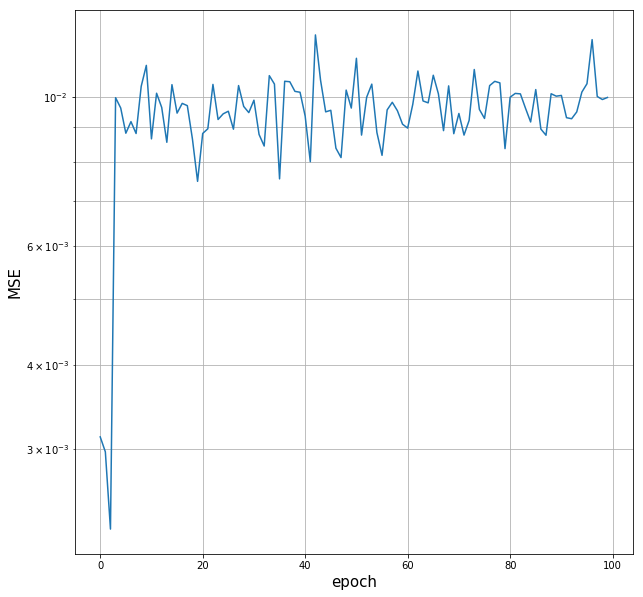

In [119]:
plt.figure(figsize = (10,10))
plt.plot(loss_history)
plt.yscale('log')
plt.grid(axis = 'both', which = 'both')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize= 15)

Text(0,0.5,'MSE')

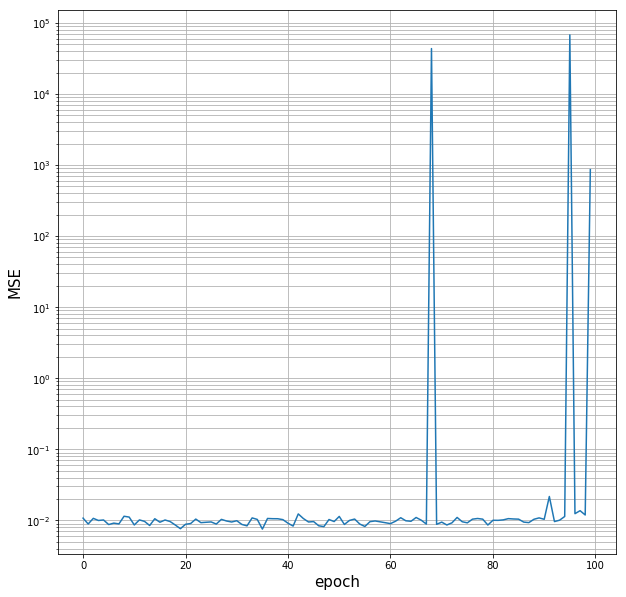

In [42]:
plt.figure(figsize = (10,10))
plt.plot(loss_history)
plt.yscale('log')
plt.grid(axis = 'both', which = 'both')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize= 15)

Text(0,0.5,'MSE')

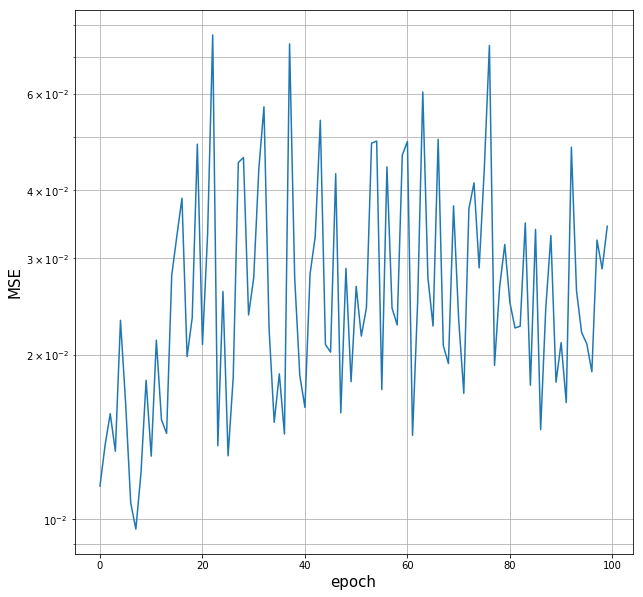

In [45]:
plt.figure(figsize = (10,10))
plt.plot(loss_history)
plt.yscale('log')
plt.grid(axis = 'both', which = 'both')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize= 15)

# Model for 32x32 images (Machine Y)

In [26]:
store = pd.HDFStore('./machine_data.h5')
df_y = store['/machine_y']
store.close()

data_y = df_y.values

In [27]:
test = list(df_y.columns)
print(test[:10])
np.random.shuffle(test)
print(test[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[7773, 1465, 11377, 18839, 6158, 8080, 16756, 3678, 12647, 21375]


In [25]:
df_y[test]

,7539,15969,10831,15044,6359,14198,23069,8292,16819,14908,...,8717,10147,18062,7736,23914,11703,2971,15017,18020,14666
0,68.0,57.0,53.0,45.0,62.0,49.0,50.0,36.0,82.0,66.0,...,50.0,70.0,45.0,50.0,32.0,70.0,47.0,51.0,71.0,76.0
1,85.0,81.0,68.0,59.0,77.0,63.0,61.0,53.0,109.0,77.0,...,62.0,83.0,60.0,61.0,51.0,101.0,66.0,78.0,90.0,99.0
2,63.0,67.0,70.0,56.0,70.0,58.0,58.0,47.0,101.0,76.0,...,54.0,82.0,52.0,54.0,44.0,88.0,54.0,66.0,81.0,83.0
3,80.0,75.0,66.0,55.0,80.0,60.0,58.0,53.0,101.0,79.0,...,59.0,82.0,60.0,57.0,48.0,91.0,65.0,73.0,82.0,98.0
4,99.0,84.0,89.0,68.0,90.0,67.0,66.0,58.0,117.0,90.0,...,59.0,86.0,66.0,67.0,55.0,101.0,70.0,84.0,102.0,111.0
5,41.0,37.0,80.0,62.0,34.0,28.0,28.0,51.0,108.0,38.0,...,30.0,41.0,27.0,60.0,49.0,95.0,71.0,74.0,42.0,41.0
6,68.0,54.0,42.0,41.0,62.0,44.0,42.0,33.0,64.0,63.0,...,44.0,59.0,41.0,48.0,32.0,58.0,35.0,41.0,62.0,61.0
7,74.0,70.0,65.0,53.0,68.0,55.0,51.0,46.0,92.0,74.0,...,52.0,78.0,51.0,55.0,41.0,79.0,57.0,61.0,82.0,90.0
8,85.0,78.0,79.0,61.0,80.0,69.0,62.0,56.0,98.0,82.0,...,64.0,82.0,61.0,59.0,54.0,103.0,70.0,78.0,93.0,102.0
9,62.0,55.0,47.0,36.0,54.0,44.0,40.0,33.0,67.0,59.0,...,41.0,61.0,41.0,44.0,27.0,62.0,44.0,40.0,60.0,65.0


In [31]:
train = data_y[:,:20000]/255.
test = data_y[:,20000:]/255.

In [32]:
SEED = 42
# SEED = 432748

m = train.shape[0] # col
n = train.shape[1] # row
train_T = train.T

# reset the tensor flow graph
reset_graph(seed=SEED)

n_inputs = 1024
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = 128
n_hidden4 = 54
n_hidden5 = 32 # codings
n_hidden6 = n_hidden4
n_hidden7 = n_hidden3
n_hidden8 = n_hidden2
n_hidden9 = n_hidden1

n_outputs = n_inputs

learning_rate = 0.01

# use Gaussian noise 
noise_level = 0.1

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='input') # name referred to when reinstantiating the model
# X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,name="hidden3")    
hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,name="hidden4")
hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu,name="hidden5")
hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.nn.relu,name="hidden6")
hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.nn.relu,name="hidden7")
hidden8 = tf.layers.dense(hidden7, n_hidden8, activation=tf.nn.relu,name="hidden8")
hidden9 = tf.layers.dense(hidden8, n_hidden9, activation=tf.nn.relu,name="hidden9")
outputs = tf.layers.dense(hidden9, n_outputs, name="outputs")        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 100
batch_size = 128

loss_history = []

np.random.seed(SEED)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        start = time.clock()
        n_batches = n // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = next_batch_no_labels(batch_size, train_T)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        loss_history.append(loss_train)
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        print("Time taken: {0} seconds".format((time.clock()-start)))
        print("")
        saver.save(sess, "./logs/machine_y_model.ckpt")

0 Train MSE: 0.0012491117
Time taken: 12.916618000000001 seconds

1 Train MSE: 0.0008738883
Time taken: 11.683914000000001 seconds

2 Train MSE: 0.0012407396
Time taken: 13.755198999999998 seconds

3 Train MSE: 0.0010270288
Time taken: 13.797563999999994 seconds

4 Train MSE: 0.0042336583
Time taken: 12.090767999999997 seconds

5 Train MSE: 0.005265629
Time taken: 12.035320999999996 seconds

6 Train MSE: 0.004721755
Time taken: 12.00977499999999 seconds

7 Train MSE: 0.0055714613
Time taken: 11.248160999999996 seconds

8 Train MSE: 0.005940235
Time taken: 11.676993999999993 seconds

9 Train MSE: 0.0047104945
Time taken: 11.95770499999999 seconds

10 Train MSE: 0.0059412327
Time taken: 11.554138000000023 seconds

11 Train MSE: 0.0049761813
Time taken: 11.408386000000007 seconds

12 Train MSE: 0.0056816963
Time taken: 11.86683099999999 seconds

13 Train MSE: 0.0042111874
Time taken: 11.954440000000005 seconds

14 Train MSE: 0.005247481
Time taken: 11.82477399999999 seconds

15 Train MSE:

Text(0,0.5,'MSE')

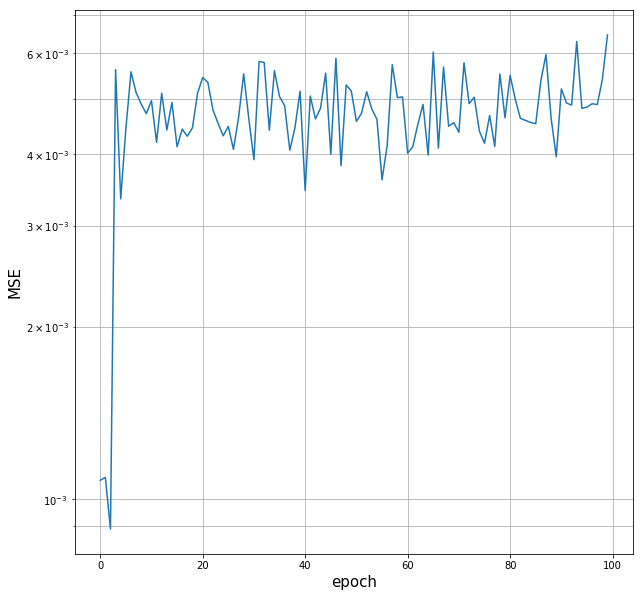

In [125]:
plt.figure(figsize = (10,10))
plt.plot(loss_history)
plt.yscale('log')
plt.grid(axis = 'both', which = 'both')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize= 15)

Text(0,0.5,'MSE')

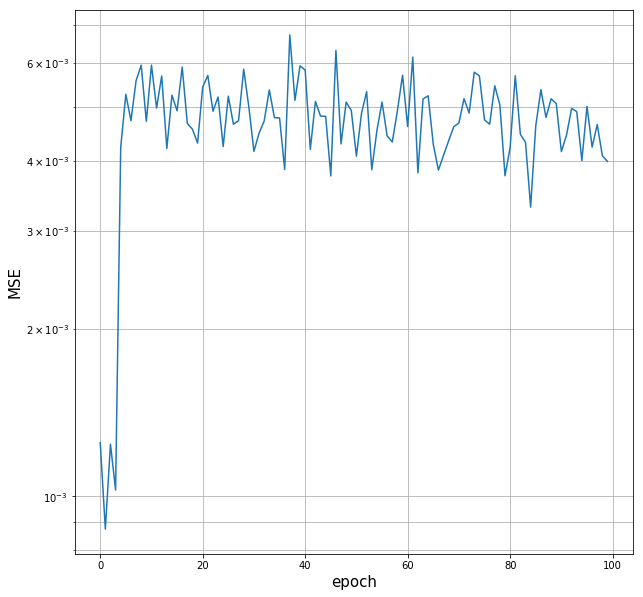

In [33]:
plt.figure(figsize = (10,10))
plt.plot(loss_history)
plt.yscale('log')
plt.grid(axis = 'both', which = 'both')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize= 15)